# Statistics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os
import subprocess

In [2]:
import scipy.stats

Data helpers

In [3]:
def wget_data(url):
    local_path='./tmp_data'
    subprocess.run(["wget", "-nc", "-P", local_path, url])

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [4]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/blobs_data.hf5')

--2026-01-26 23:01:08--  https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/blobs_data.hf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71192 (70K) [application/octet-stream]
Saving to: ‘./tmp_data/blobs_data.hf5’

     0K .......... .......... .......... .......... .......... 71% 1.97M 0s
    50K .......... .........                                  100% 18.9M=0.03s

2026-01-26 23:01:08 (2.63 MB/s) - ‘./tmp_data/blobs_data.hf5’ saved [71192/71192]



## <span style="color:Orange">Load Data</span>

In [5]:
blobs = pd.read_hdf(locate_data('blobs_data.hf5'))

## <span style="color:Orange">Statistical Methods</span>

The boundary between probability and statistics is somewhat gray (similar to astronomy and astrophysics).  However, you can roughly think of statistics as the applied cousin of probability theory.

### <span style="color:LightGreen">Expectation</span>

Given a probability density $P(x,y)$, and an arbitrary function $g(x,y)$ of the same random variables, the <span style="color:violet">expectation value</span> of $g$ is defined as:

$$ \Large
\langle g\rangle \equiv \iint dx dy\, g(x,y) P(x,y) \; .
$$

Note that the result is just a number, and not a function of either $x$ or $y$. Also, $g$ might have dimensions, which do not need to match those of the probability density $P$, so $\langle g\rangle$ generally has dimensions.

Sometimes the assumed PDF is indicated with a subscript, $\langle g\rangle_P$, which is helpful, but more often not shown.

When $g(x,y) = x^n$, the resulting expectation value is called a **moment of x**. (The same definitions apply to $y$, via $g(x,y) = y^n$.) The case $n=0$ is just the normalization integral $\langle \mathbb{1}\rangle = 1$.  Low-order moments have familiar names:
 - $n=1$ yields the <span style="color:violet">mean of x</span>, $\overline{x} \equiv \langle x\rangle$.
 - $n=2$ yields the <span style="color:violet">root-mean square (RMS) of x</span>, $\langle x^2\rangle$.
 
Another named expectation value is the <span style="color:violet">variance of x</span>, which combines the mean and RMS,

$$ \Large
\sigma_x^2 \equiv \langle\left( x - \overline{x} \right)^2\rangle \; ,
$$

where $\sigma_x$ is called the <span style="color:violet">standard deviation of x</span>.

Finally, the __<span style="color:violet">correlation between x and y</span>__ is defined as:

$$ \Large
\text{Corr}_{xy} \equiv \langle\left( x - \overline{x}\right) \left( y - \overline{y}\right)\rangle \; .
$$

A useful combination of the correlation and variances is the <span style="color:violet">correlation coefficient</span>,

$$ \Large
\rho_{xy} \equiv \frac{\text{Corr}_{x,y}}{\sigma_x \sigma_y} \; ,
$$

which, by construction, must be in the range $[-1, +1]$. Larger values of $|\rho_{xy}|$ indicate that $x$ and $y$ are measuring related properties of the outcome so, together, carry less information than when $\rho_{xy} \simeq 0$. In the limit of $|\rho_{xy}| = 1$, $y = y(x)$ is entirely determined by $x$, so carries no new information.

We say that the variance and correlation are both *second-order moments* since they are expectation values of second-degree polynomials.

We call the random variables $x$ and $y$ <span style="color:violet">uncorrelated</span> when:

$$ \Large
x,y\, \text{uncorrelated}\quad\Rightarrow\quad \text{Corr}_{xy} = \rho_{xy} = 0 \; .
$$

To obtain an <span style="color:violet">empirical estimate</span> of the quantities above derived from your data, use the corresponding numpy functions, e.g.

In [6]:
np.mean(blobs, axis=0)

x0    6.920270
x1    4.502004
x2    8.492347
dtype: float64

In [7]:
np.var(blobs, axis=0)

x0    12.684951
x1     6.807913
x2    15.503924
dtype: float64

In [8]:
np.std(blobs, axis=0)

x0    3.561594
x1    2.609198
x2    3.937502
dtype: float64

In [9]:
assert np.allclose(np.std(blobs, axis=0) ** 2, np.var(blobs, axis=0))

In [10]:
assert np.allclose(
    np.mean((blobs - np.mean(blobs, axis=0)) ** 2, axis=0),
    np.var(blobs, axis=0))

The definition 

$$ \Large
\sigma_x^2 = \langle\left( x - \overline{x} \right)^2\rangle
$$

suggests that two passes through the data are necessary to calculate variance: one to calculate $\overline{x}$ and another to calculate the residual expectation. Expanding this definition, we obtain a formula

$$ \Large
\sigma_x^2 = \langle x^2\rangle - \langle x\rangle^2
$$

that can be evaluated in a single pass by simultaneously accumulating the first and second moments of $x$. However, this approach should generally not be used since it involves a cancellation between relatively large quantities that is subject to large round-off error. More details and recommended one-pass (aka "online") formulas are [here](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance).

### <span style="color:LightGreen">Covariance</span>

It is useful to construct the <span style="color:violet">covariance matrix</span> $C$ with elements:

$$ \Large
C \equiv \begin{bmatrix}
\sigma_x^2 & \rho_{x,y} \sigma_x \sigma_y \\
\rho_{x,y} \sigma_x \sigma_y & \sigma_y^2 \\
\end{bmatrix}
$$

With more than 2 random variables, $x_0, x_1, \ldots$, this matrix generalizes to:

$$ \Large
C_{ij} = \langle \left( x_i - \overline{x}_i\right) \left( x_j - \overline{x}_j\right)\rangle \; .
$$

Comparing with the definitions above, we find variances on the diagonal:

$$ \Large
C_{ii} = \sigma_i^2
$$

and symmetric correlations on the off-diagonals:

$$ \Large
C_{ij} = C_{ji} = \rho_{ij} \sigma_i \sigma_j \; .
$$

(The covariance is not only symmetric but also [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix)).

The covariance matrix is similar to a pairplot, with each $2\times 2$ submatrix

$$ \Large
\begin{bmatrix}
\sigma_i^2 & \rho_{ij} \sigma_i \sigma_j \\
\rho_{ij} \sigma_i \sigma_j & \sigma_j^2 \\
\end{bmatrix}
$$

describing a 2D elllipse in the $(x_i, x_j)$ plane:

<div>
<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/Statistics-Ellipse.png" width=800></img>
</div>

Note that you can directly read off the correlation coefficient $\rho_{ij}$ from any of the points where the ellipse touches its bounding box. The ellipse rotation angle $\theta$ is given by:

$$ \Large
\tan 2\theta = \frac{2 C_{ij}}{C_{ii} - C_{jj}} = \frac{2\rho_{ij}\sigma_i\sigma_j}{\sigma_i^2 - \sigma_j^2}
$$

and its [principal axes](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes) have lengths:

$$ \Large
a_\pm = 2\sqrt{C_{ii} + C_{jj} \pm d} \quad \text{with} \quad
d = \sqrt{C_{11}^2 - 2 (1 - 2\rho^2) C_{11} C_{22} + C_{22}^2} \; .
$$

For practical calculations, the <span style="color:violet">Singular Value Decomposition</span> (SVD) of the covariance is useful:

```
U, s, _ = np.linalg.svd(C)
theta = np.arctan2(U[1, 0], U[0, 0])
ap, am = 2 * np.sqrt(s)
```

The above assumes $C$ is $2\times 2$. In the general $D\times D$ case, use `C[[[j], [i]], [[j, i]]]` to pick out the $(i,j)$ $2\times 2$ submatrix.

A multivariate Gaussian PDF integrated over this ellipse (and marginalized over any additional dimensions) has a total probability of about 39%, also known as its <span style="color:violet">confidence level</span> (CL).  We will see below how to calculate this CL and scale the ellipse for other CLs.

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE</span>___: Calculate the empirical covariance matrix of the `blobs` dataset using `np.cov` (pay attention to the `rowvar` arg). Next, calculate the ellipse rotation angles $\theta$ in degrees for each of this matrix's 2D projections.

In [11]:
C = np.cov(blobs, rowvar=False)
for i in range(3):
    for j in range(i + 1, 3):
        U, s, _ = np.linalg.svd(C[[[j], [i]], [[j, i]]])
        theta = np.arctan2(U[1, 0], U[0, 0])
        print(i, j, np.round(np.degrees(theta), 1))

0 1 123.3
0 2 -138.2
1 2 151.0


<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

Recall that the `blobs` data was generated as a mixture of three Gaussian blobs, each with different parameters. However, describing a dataset with a single covariance matrix suggests a single Gaussian model. The lesson is that 
we can calculate an empirical covariance for *any* data, whether or not it is well described a single Gaussian.

## <span style="color:Orange">Jensen's Inequality</span>

[Convex functions](https://en.wikipedia.org/wiki/Convex_function) play a special role in optimization algorithms (which we will talk more about soon) since they have a single global minimum with no secondary local minima. The parabola $g(x) = a (x - x_0)^2 + b$ is a simple 1D example, having its minimum value of $b$ at $x = x_0$, but convex functions can have any dimensionality and need not be parabolic (second order).

Expectations involving a convex function $g$ satisfy [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality), which we will use later:

$$ \Large
g(\langle \vec{x} \ldots\rangle) \le \langle g(\vec{x})\rangle \; .
$$

In other words, the expectation value of $g$ is bounded below by $g$ evaluated at the PDF mean, for any PDF. Note that the two sides of this equation swap the order in which the operators $g(\cdot)$ and $\langle\cdot\rangle$ are applied to $\vec{x}$.

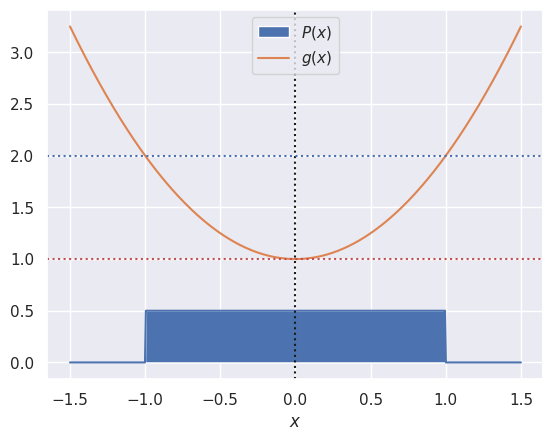

In [12]:
def jensen(a=1, b=1, c=1):
    x = np.linspace(-1.5 * c, 1.5 * c, 500)
    g = a * x ** 2 + b
    P = (np.abs(x) < c) * 0.5 / c
    plt.fill_between(x, P, label='$P(x)$')
    plt.plot(x, P)
    plt.plot(x, g, label='$g(x)$')
    plt.legend(loc='upper center', frameon=True)
    plt.axvline(0, c='k', ls=':')
    plt.axhline(b, c='r', ls=':')
    plt.axhline(a * c ** 2 + b, c='b', ls=':')
    plt.xlabel('$x$')
    
jensen()

<hr style="border:1px solid rgba(255, 255, 255, 1); margin: 2em 0;">

___<span style="color:violet">EXERCISE</span>___: Match the following values to the dotted lines in the graph above of the function $g(x)$ and probability density $P(x)$:
 1. $\langle x\rangle = \int dx\, x P(x)$
 
 2. $\langle g(x)\rangle = \int dx\, g(x)\,P(x)$
 
 3. $g(\langle x\rangle) = g\left( \int dx\, x P(x)\right)$
 
Is $g(x)$ convex? Is Jensen's inequality satisfied?

<span style="color:LightGreen">Answer</span>:
 1. Vertical (black) line.

 2. Upper horizontal (blue) line.

 3. Lower horizontal (red) line.
 
Jensen's inequality is satisfied, as required since $g(x)$ is convex.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2026